# PEFT

### Library

In [1]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import default_data_collator

import pandas as pd

import torch
from transformers import AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
from tqdm import tqdm


In [2]:
!pip show torch torchvision torchaudio 

Name: torch
Version: 2.4.0.dev20240501+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: C:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: filelock, fsspec, jinja2, mkl, networkx, sympy, typing-extensions
Required-by: accelerate, peft, pytorch-lightning, sentence-transformers, thop, torchaudio, torchmetrics, torchvision, ultralytics
---
Name: torchvision
Version: 0.19.0.dev20240502+cu121
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: C:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: numpy, pillow, torch
Required-by: sentence-transformers, ultralytics
---
Name: torchaudio
Version: 2.2.0.dev20240502+cu121
Summary: An au

## Dataset

In [4]:
ds = load_dataset("financial_phrasebank", "sentences_allagree")
ds = ds["train"].train_test_split(test_size=0.1)
ds["validation"] = ds["test"]
del ds["test"]


In [5]:
classes = ds["train"].features["label"].names
ds = ds.map(
    lambda x: {"text_label": [classes[label] for label in x["label"]]},
    batched=True,
    num_proc=1,
)

Map:   0%|          | 0/2037 [00:00<?, ? examples/s]

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

Load a tokenizer and create a preprocessing function that:

1. tokenizes the inputs, pads and truncates the sequence to the max_length

2. apply the same tokenizer to the labels but with a shorter max_length that corresponds to the label

3. mask the padding tokens

In [7]:
from transformers import AutoTokenizer

text_column = "sentence"
label_column = "text_label"
max_length = 128

tokenizer = AutoTokenizer.from_pretrained("bigscience/mt0-large")

In [6]:
def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    model_inputs = tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt", return_attention_mask = True)
    labels = tokenizer(targets, max_length=3, padding="max_length", truncation=True, return_tensors="pt", return_attention_mask = True)
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels
    return model_inputs 

In [7]:
processed_ds = ds.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=ds["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/2037 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/227 [00:00<?, ? examples/s]

In [8]:
processed_ds

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2037
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 227
    })
})

* input_ids: numerical representations of your tokens.

* attention_mask: indicates which tokens should be attended to.

In [9]:
pd.DataFrame(processed_ds["train"])

,input_ids,attention_mask,labels
0,"[1477, 2456, 304, 287, 161414, 1300, 259, 261,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[59006, 1, -100]"
1,"[563, 18072, 288, 2476, 259, 96189, 281, 16782...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[59006, 1, -100]"
2,"[143129, 262, 91406, 259, 261, 259, 23286, 259...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[18205, 1, -100]"
3,"[486, 259, 123403, 259, 261, 514, 1388, 1251, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[59006, 1, -100]"
4,"[47348, 339, 259, 25505, 288, 390, 259, 58705,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[59006, 1, -100]"
...,...,...,...
2032,"[515, 143136, 63927, 19149, 5835, 259, 31842, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[18205, 1, -100]"
2033,"[486, 2262, 304, 287, 2956, 6245, 259, 23606, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[59006, 1, -100]"
2034,"[486, 28273, 305, 16860, 304, 12174, 30632, 13...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[59006, 1, -100]"
2035,"[259, 52356, 259, 45814, 8170, 305, 5284, 1768...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[18205, 1, -100]"


In [10]:
train = processed_ds["train"]
validation = processed_ds["validation"]
batch_size = 8


train_dataloader = DataLoader(train, batch_size = batch_size, shuffle=True, collate_fn=default_data_collator, pin_memory=True)
validation_dataloader = DataLoader(validation, batch_size = batch_size, shuffle=True, collate_fn=default_data_collator, pin_memory=True)

## Model

Now you can load a pretrained model to use as the base model for IA3. 

In [11]:
from transformers import AutoModelForSeq2SeqLM

# Download model and configuration from huggingface.co and cache.
model = AutoModelForSeq2SeqLM.from_pretrained("bigscience/mt0-large")

C:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


All PEFT methods (using hugging face) need a configuration that contains and specifies all the parameters for how the PEFT method should be applied.

In [12]:
from peft import IA3Config, get_peft_model

peft_config = IA3Config(task_type="SEQ_2_SEQ_LM")
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 282,624 || all params: 1,229,863,936 || trainable%: 0.022980103060766553


## Training

In [13]:
print(torch.backends.cudnn.enabled)
print(torch.cuda.is_available())

True
True


Set up an optimizer and learning rate scheduler.

In [14]:
lr = 8e-3
num_epochs = 3

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

Move the model to the GPU and create a training loop that reports the loss and perplexity for each epoch.

In [15]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 128]),
 'attention_mask': torch.Size([8, 128]),
 'labels': torch.Size([8, 3])}

In [10]:
device = "cuda"

In [27]:

model = model.to(device)


train_loss_values = []
validation_loss_values = []
epoch_count = []

for epoch in range(num_epochs):
     model.train()
     for step, batch in enumerate(tqdm(train_dataloader)):
          batch = {k: v.to(device) for k, v in batch.items()}
          optimizer.zero_grad()
          pred = model(**batch) #unpack the dictionary by adding **
          train_loss = pred.loss
          train_loss.backward()
          optimizer.step()
          lr_scheduler.step()
          
     model.eval()
     validation_pred = []
     for  step, batch in enumerate(tqdm(validation_dataloader)):
          batch = {k: v.to(device) for k, v in batch.items()}
          with torch.no_grad():
               pred = model(**batch) 
          validation_loss = pred.loss
          validation_pred.extend(
            tokenizer.batch_decode(torch.argmax(pred.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
          )#Here, the model's predictions are decoded using the tokenizer, finds the indices of the maximum value along the last dimension(category) of the logits tensor, which has the highest probability. 
           # Detaches the tensor from the computational graph and moves it to the CPU before converting it to a NumPy array
     
     
     epoch_count.append(epoch)
     train_loss_values.append(train_loss.detach().cpu().numpy())
     validation_loss_values.append(validation_loss.detach().cpu().numpy())
     print(f"Epoch: {epoch} | Train Loss: {train_loss} | Validation Loss: {validation_loss} ")
          
          

100%|██████████| 29/29 [01:38<00:00,  3.38s/it]


Epoch: 0 | Train Loss: 0.0007337260176427662 | Validation Loss: 0.0012056477135047317 


100%|██████████| 29/29 [01:51<00:00,  3.83s/it]


Epoch: 1 | Train Loss: 0.019395597279071808 | Validation Loss: 0.000471688894322142 


100%|██████████| 29/29 [01:40<00:00,  3.46s/it]

Epoch: 2 | Train Loss: 0.0025813968386501074 | Validation Loss: 0.0015307172434404492 


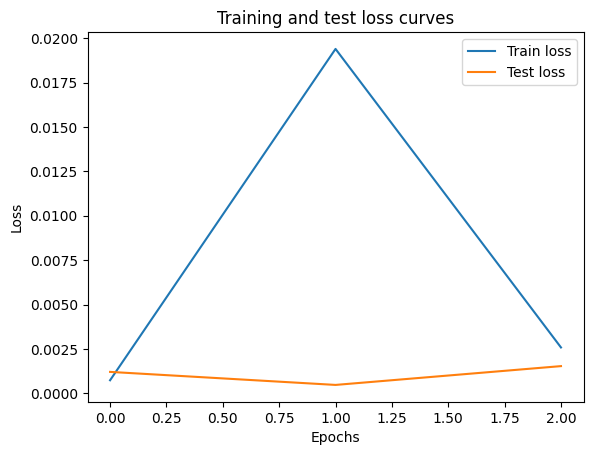

In [31]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, validation_loss_values, label="validation loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## Share your model

In [39]:
from huggingface_hub import notebook_login

notebook_login()

In [40]:
from huggingface_hub import notebook_login

account = 'BluedreamV1B3'
peft_model_id = f"{account}/mt0-large-ia3-test"
model.push_to_hub(peft_model_id)

adapter_model.bin:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/BluedreamV1B3/mt0-large-ia3-test/commit/c7163f2a6f0910a79c881bb0b87b42c78436daad', commit_message='Upload model', commit_description='', oid='c7163f2a6f0910a79c881bb0b87b42c78436daad', pr_url=None, pr_revision=None, pr_num=None)

## Inference

In [2]:
from peft import AutoPeftModelForSeq2SeqLM

model = AutoPeftModelForSeq2SeqLM.from_pretrained("BluedreamV1B3/mt0-large-ia3-test").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("bigscience/mt0-large")

C:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


adapter_model.bin:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

C:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jonathan\.cache\huggingface\hub\models--BluedreamV1B3--mt0-large-ia3-test. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [12]:
i = 14 #randomly pick an observation
inputs = tokenizer(ds["validation"][text_column][i], return_tensors="pt")
print(ds["validation"][text_column][i])

Food sales totalled EUR 323.5 mn in October 2009 , representing a decrease of 5.5 % from October 2008 .


In [13]:
with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(input_ids=inputs["input_ids"], max_new_tokens=10)
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True))

['negative']
